In [1]:
import pickle as pkl
import datetime

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import scipy as sp
from scipy import signal

%matplotlib inline

In [2]:
mpl.rcParams['font.size']      = 18
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = 1.5*np.array([8.0, 6.0])
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

In [3]:
fpath = 'output/ham_tec_4plot/ham_tec_4plot.png-tec_ts.p'

In [4]:
with open(fpath,'rb') as fl:
    tec_ts = pkl.load(fl)

In [5]:
tec_ts[0]

{'gec_naf_us_rgn': 37.2971,
 'gtid_naf_us_rgn': 0.0508,
 'gec_std_naf_us_rgn': 16.765371,
 'gtid_std_naf_us_rgn': 0.5526592,
 'gec_naf_us_left': 39.2406,
 'gtid_naf_us_left': 0.03645,
 'gec_std_naf_us_left': 14.741564,
 'gtid_std_naf_us_left': 0.5175812,
 'gec_naf_us_mid': 16.8558,
 'gtid_naf_us_mid': 0.0528,
 'gec_std_naf_us_mid': 16.05086,
 'gtid_std_naf_us_mid': 0.47281605,
 'gec_naf_us_right': 10.8479,
 'gtid_naf_us_right': -0.00205,
 'gec_std_naf_us_right': 14.246593,
 'gtid_std_naf_us_right': 0.37277332,
 'gec_naf_us': 39.408447,
 'gtid_naf_us': 0.04145,
 'gec_std_naf_us': 14.574733,
 'gtid_std_naf_us': 0.49703413,
 'gec': 8.9913,
 'gecus': 8.63575,
 'gtidus': -0.0313,
 'gecus_std': 1.9185491,
 'gtidus_std': 0.21759655,
 'gecus_mid': 8.4345,
 'gtidus_mid': -0.0828,
 'gecus_std_mid': 1.2164339,
 'gtidus_std_mid': 0.33598292,
 'gecus_left': 6.6144,
 'gtidus_left': -0.02665,
 'gecus_std_left': 1.8051671,
 'gtidus_std_left': 0.08728137,
 'gecus_right': 9.5427,
 'gtidus_right': -0.039

In [6]:
dts      = []
dt_hours = []
gtid     = []

for tec in tec_ts:
    dts.append(tec['gps_date'])
    dt_hours.append(tec['gps_hour'])
    gtid.append(tec['gtidus'])

dts         = dts[:-1]
dt_hours    = dt_hours[:-1]
gtid        = gtid[:-1]

dts         = np.array(dts)
dt_hours    = np.array(dt_hours)
gtid        = np.array(gtid)

hr_lim = (12,24)
tf = np.logical_and(dt_hours >= hr_lim[0], dt_hours < hr_lim[1])

dts         = dts[tf]
dt_hours    = dt_hours[tf]
gtid        = gtid[tf]

Ts = np.diff(dts)[0].total_seconds()
fs = 1/Ts

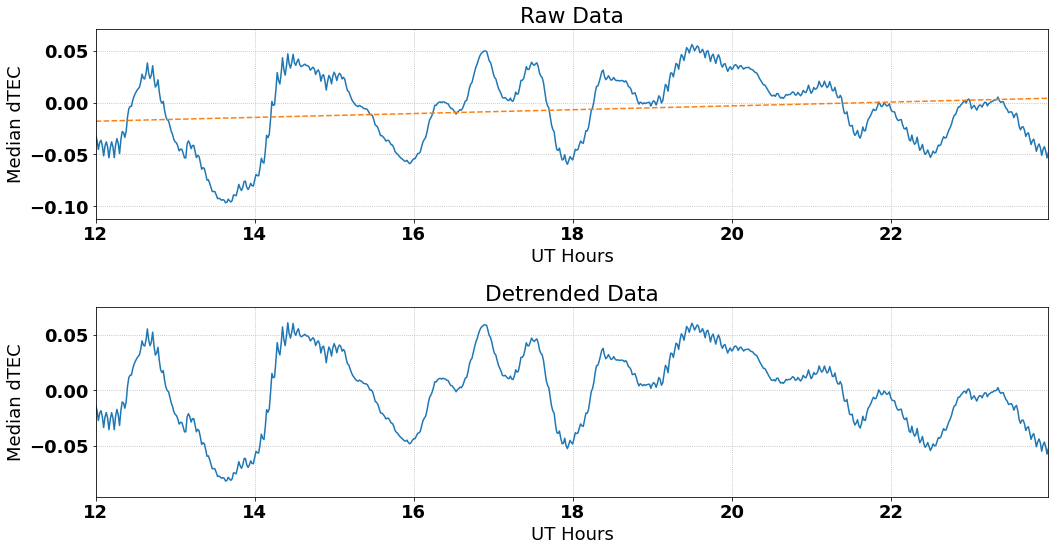

In [7]:
regress = sp.stats.linregress(dt_hours,gtid)
line    = regress.slope*dt_hours + regress.intercept

fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(211)
ax.plot(dt_hours,gtid)
ax.plot(dt_hours,line,ls='--')
ax.set_xlabel('UT Hours')
ax.set_ylabel('Median dTEC')
ax.set_title('Raw Data')

gtid_detrend = gtid - line
ax  = fig.add_subplot(212)
ax.plot(dt_hours,gtid_detrend)
ax.set_xlabel('UT Hours')
ax.set_ylabel('Median dTEC')
ax.set_title('Detrended Data')

fig.tight_layout()

plt.show()

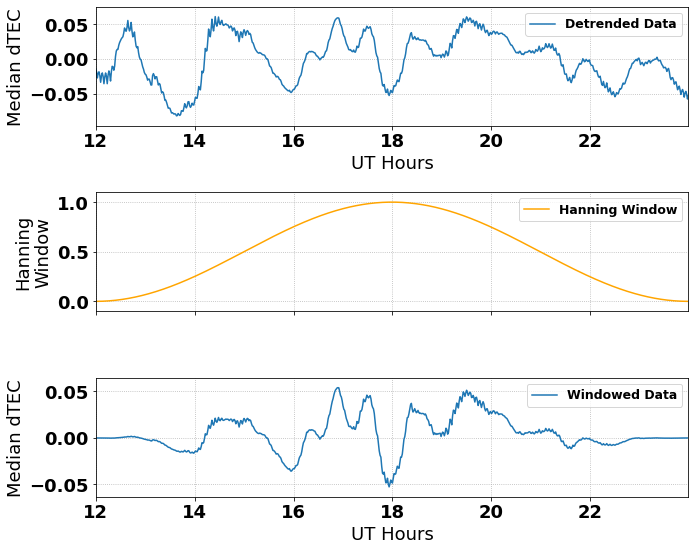

In [8]:
han_win       = np.hanning(len(gtid_detrend))
gtid_han      = han_win*gtid_detrend

# Plot the sinusoid - first 0.1 seconds.
fig = plt.figure(figsize=(10,8))

ax  = fig.add_subplot(3,1,1)
lbl = 'Detrended Data'
ax.plot(dt_hours,gtid_detrend,label=lbl)
ax.set_xlabel('UT Hours')
ax.set_ylabel('Median dTEC')
ax.legend(loc='upper right',fontsize='x-small')

ax  = fig.add_subplot(3,1,2)
lbl = 'Hanning Window'
ax.plot(dt_hours,han_win,label=lbl,color='orange')
ax.set_xticklabels([])
ax.set_ylabel('Hanning\nWindow')
ax.legend(loc='upper right',fontsize='x-small')

ax  = fig.add_subplot(3,1,3)
lbl = 'Windowed Data'
ax.plot(dt_hours,gtid_han,label=lbl)
ax.set_xlabel('UT Hours')
ax.set_ylabel('Median dTEC')
ax.legend(loc='upper right',fontsize='x-small')

fig.tight_layout()
plt.show()

# Compute FFT

In [9]:
# Compute the FFT.
X0 = np.fft.fft(gtid_han)*Ts*2

# Reorder values so they go in frequency order from negative to positive.
X0 = np.fft.fftshift(X0)

f_vec = np.fft.fftfreq(len(X0),Ts)
f_vec = np.fft.fftshift(f_vec)

# Take positive frequencies only.
tf    = f_vec >= 0
X0    = X0[tf]
f_vec = f_vec[tf]

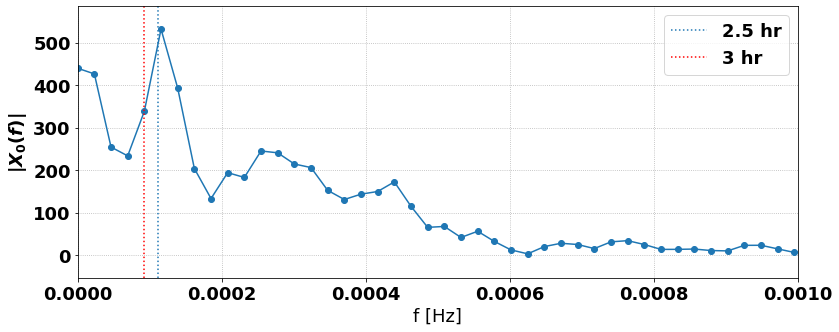

In [10]:
fig = plt.figure()

xlim = (0,0.001)

ax  = fig.add_subplot(2,1,1)
ax.plot(f_vec,np.abs(X0),marker='o')
ax.set_ylabel('$|X_0(f)|$')
ax.set_xlim(xlim)
ax.set_xlabel('f [Hz]')

T_hr = 2.5
f_sec = 1/(T_hr*3600.)
lbl   = '{!s} hr'.format(T_hr)
ax.axvline(f_sec,ls=':',label=lbl)

T_hr = 3
f_sec = 1/(T_hr*3600.)
lbl   = '{!s} hr'.format(T_hr)
ax.axvline(f_sec,ls=':',label=lbl,color='r')

ax.legend(loc='upper right')

fig.tight_layout()
plt.show()

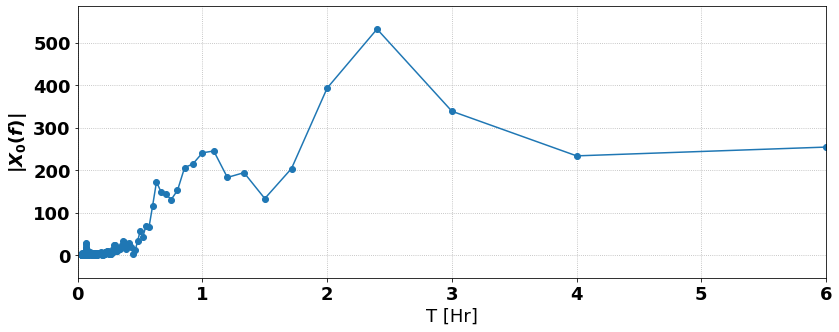

In [11]:
T_hr_vec = 1./(f_vec*3600.)
xlim = (0,6)
fig = plt.figure()

ax  = fig.add_subplot(2,1,1)

xx  = (T_hr_vec[::-1])[1:]
yy  = (np.abs(X0)[::-1])[1:]

ax.plot(xx,yy,marker='o')
ax.set_ylabel('$|X_0(f)|$')
ax.set_xlim(xlim)
ax.set_xlabel('T [Hr]')

fig.tight_layout()
plt.show()

In [12]:
xx[np.argmax(yy)]

2.4000000000000004

# Define filter

[6.94444444e-05 1.38888889e-04]


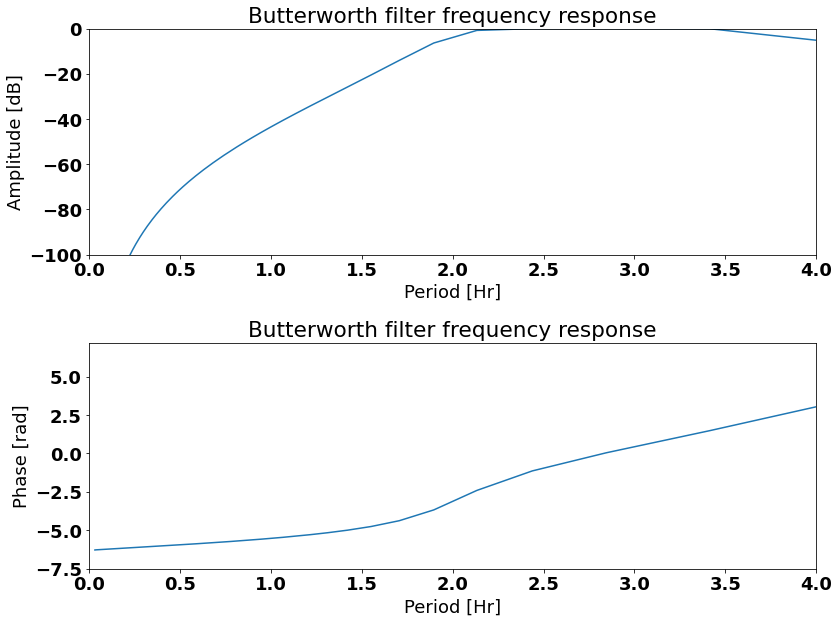

In [26]:
#Wn    = 0.0003    # 3 dB Cutoff Frequency in Hz
Wn_hr = (2, 4)
Wn    = 1./((np.array(Wn_hr)[::-1])*3600)

print(Wn)

btype = 'bandpass'  # Choose 'low' or 'high'

b, a = signal.butter(4, Wn, btype, fs=fs)
w, h = signal.freqz(b, a)

f = (fs/2)*(w/(np.pi))
T_hr = (1/f)/3600.

plt.subplot(211)
# plt.plot(f, 20 * np.log10(abs(h)))
plt.plot(T_hr, 20 * np.log10(abs(h)))

# plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Period [Hr]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
#plt.axvline(Wn, color='green') # cutoff frequency
plt.xlim(0,4)
plt.ylim(-100,0)

plt.subplot(212)
plt.plot(T_hr, np.unwrap(np.angle(h)))
# plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Period [Hr]')
plt.ylabel('Phase [rad]')
plt.grid(which='both', axis='both')
#plt.axvline(Wn, color='green') # cutoff frequency
plt.xlim(0,4)


plt.tight_layout()
plt.show()

In [27]:
gtidus_mids_3 = signal.filtfilt(b,a,gtid_detrend)


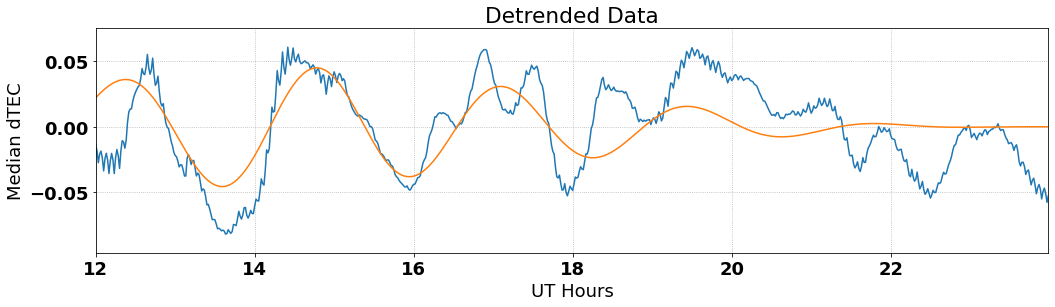

In [28]:
fig = plt.figure(figsize=(15,8))
ax  = fig.add_subplot(211)
ax.plot(dt_hours,gtid_detrend)
ax.plot(dt_hours,gtidus_mids_3)
ax.set_xlabel('UT Hours')
ax.set_ylabel('Median dTEC')
ax.set_title('Detrended Data')

fig.tight_layout()

plt.show()

In [25]:
# Compute the FFT.
X0 = np.fft.fft(gtidus_mids_3)*Ts*2

# Reorder values so they go in frequency order from negative to positive.
X0 = np.fft.fftshift(X0)

f  = np.fft.fftfreq(len(X0),Ts)
f  = np.fft.fftshift(f)

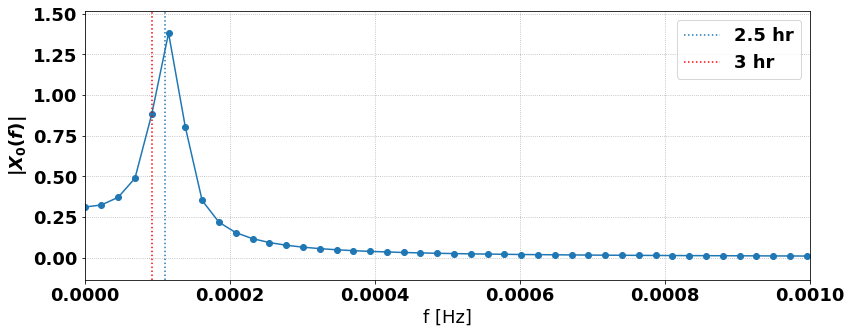

In [17]:
fig = plt.figure()

xlim = (0,0.001)

ax  = fig.add_subplot(2,1,1)
ax.plot(f,np.abs(X0),marker='o')
ax.set_ylabel('$|X_0(f)|$')
ax.set_xlim(xlim)
ax.set_xlabel('f [Hz]')

T_hr = 2.5
f_sec = 1/(T_hr*3600.)
lbl   = '{!s} hr'.format(T_hr)
ax.axvline(f_sec,ls=':',label=lbl)

T_hr = 3
f_sec = 1/(T_hr*3600.)
lbl   = '{!s} hr'.format(T_hr)
ax.axvline(f_sec,ls=':',label=lbl,color='r')

ax.legend(loc='upper right')

fig.tight_layout()
plt.show()